## Food Pantry Data Cleaning 
* Author: Callie Clark (last updated 6/4/2024)
* Clean location data
* Parse time data

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
import zipfile
import io
import re
import numpy as np
from collections import Counter

In [14]:
df=pd.read_csv('food_pantries_2023.csv') 
df.head()

,Unnamed: 0,Name,Address,Additional Notes,Source FINAL,Status FINAL,Status FPC,Status Plentiful,Last Updated FINAL,Last Updated FPC,...,Hours FPC,Hours Plentiful,Website,ID Required,Zipcode,lat,lng,City,State,id
0,0,St. Albans Baptist Church,196-20 119th Ave,- Will not refuse anyone even if they don't ha...,FPC,open,open,unknown,2/2/2023 7:00 PM,2/3/2023,...,"Sa 10:00AM-12:00PM ""every first and third Satu...",NaN,https://www.sabcny.org/,yes,11412,40.690698,-73.753923,Queens,NY,03f3326e-7b52-4fdb-af71-5bece2b0a088
1,1,Love Gallery Our Food NYC,1254 Myrtle Ave,- While supplies last\n- Currently have mainly...,FPC,closed,closed,NaN,4/20/2023 8:00 PM,4/21/2023,...,We 07:00AM-12:00PM,NaN,https://paperboyprince.com/love-gallery/,no,11221,40.697899,-73.927148,Brooklyn,NY,76f34b7f-c166-4b76-831e-2a985ceb36d6
2,2,"Project Hospitality, SHINE Center",205 Canal St,- Wednesday is only open for people with chron...,FPC,closed,closed,NaN,5/3/2023 8:00 PM,5/4/2023,...,"Tu,Th 09:00AM-12:00PM",NaN,http://www.projecthospitality.org/,unknown,10304,40.625155,-74.079924,Staten Island,NY,23c93c1e-2500-43f5-ab0c-f71365866398
3,3,The Center for Family Life,443 39th St,- Vouchers/tickets are only given out to the f...,FPC,open,open,NaN,5/9/2023 8:00 PM,5/10/2023,...,"tu,we,th 01:00PM-04:00PM",NaN,https://centerforfamilylife.org/community-serv...,yes,11232,40.652009,-74.004742,Brooklyn,NY,22a2afb1-308b-4083-be89-c7d5902a8b2f
4,4,Family Services Network of New York,1420 Bushwick Ave,- Visitors will not be denied if they do not h...,FPC,open,open,unknown,4/30/2023 8:00 PM,5/1/2023,...,"Mo,We 09:00AM-01:00PM",NaN,https://fsnny1.org,yes,11207,40.684120,-73.909235,Brooklyn,NY,369d7a47-7352-4544-b5d7-06197db37f14


In [15]:
df.dropna(how='all',inplace=True)
df=df[df['Status FINAL']!='closed']# removed closed locations
print('# open food pantries',len(df))
df.head()

# open food pantries 1250


,Unnamed: 0,Name,Address,Additional Notes,Source FINAL,Status FINAL,Status FPC,Status Plentiful,Last Updated FINAL,Last Updated FPC,...,Hours FPC,Hours Plentiful,Website,ID Required,Zipcode,lat,lng,City,State,id
0,0,St. Albans Baptist Church,196-20 119th Ave,- Will not refuse anyone even if they don't ha...,FPC,open,open,unknown,2/2/2023 7:00 PM,2/3/2023,...,"Sa 10:00AM-12:00PM ""every first and third Satu...",NaN,https://www.sabcny.org/,yes,11412,40.690698,-73.753923,Queens,NY,03f3326e-7b52-4fdb-af71-5bece2b0a088
3,3,The Center for Family Life,443 39th St,- Vouchers/tickets are only given out to the f...,FPC,open,open,NaN,5/9/2023 8:00 PM,5/10/2023,...,"tu,we,th 01:00PM-04:00PM",NaN,https://centerforfamilylife.org/community-serv...,yes,11232,40.652009,-74.004742,Brooklyn,NY,22a2afb1-308b-4083-be89-c7d5902a8b2f
4,4,Family Services Network of New York,1420 Bushwick Ave,- Visitors will not be denied if they do not h...,FPC,open,open,unknown,4/30/2023 8:00 PM,5/1/2023,...,"Mo,We 09:00AM-01:00PM",NaN,https://fsnny1.org,yes,11207,40.684120,-73.909235,Brooklyn,NY,369d7a47-7352-4544-b5d7-06197db37f14
5,5,Jamaica Hispanic SDA Church,88-28 161st St,- Visitors will be required to identify how ma...,FPC,open,open,unknown,2/2/2023 7:00 PM,2/3/2023,...,Su 08:00AM-09:00AM,NaN,https://www.facebook.com/pages/category/Sevent...,no,11432,40.707286,-73.800950,Queens,NY,b1d98238-9b1a-4ab4-9046-2cb06b9baa44
6,6,New York City Love Kitchen - Food Pantry,3816 9th Ave,- Visitors need to call to register before arr...,FPC,open,open,unknown,2/8/2023 7:00 PM,2/9/2023,...,"We 11:00AM-12:00PM ""1st and 3rd Wednesday of t...",NaN,https://www.nyclovekitchen.com,no,10034,40.862233,-73.918484,New York,NY,c0a0e9c6-11ce-4094-98a1-e16e1a5f32c3


In [16]:
#flag data outsideNYC five boroughs
df[(df['lng']>-73.5)|(df['lng']<-74.5)|(df['lat']>41.0)|(df['lat']<40.5)][['id', 'Name', 'Address', 'lat', 'lng']]#['id'].values
                                                                          
                                                                          

,id,Name,Address,lat,lng
529,28955779-d06b-46b0-98a9-ddddd72c639c,Trinity Evangelical Lutheran Church - Soup Kit...,716 Route 25A,40.947059,-72.916757
1049,b3df8ebd-47ce-429f-9328-24863d4cffe8,Trinity Evangelical Lutheran Church - Food Pantry,716 Route 25A,42.099549,-71.252735
1244,7dad13fa-4ee3-4b6c-bb42-8ee7e7da1216,Fred's Pantry,132 N Division St,41.292343,-73.919754
1277,14fe0635-ade9-4664-96bf-e7f26243917c,"ACT Care Foundation, Inc.",1698 Victory Blvd,34.184364,-118.329298
1378,9ebe0c40-21b9-42e2-9645-221dd1bfae10,HALO Community Outreach,PO Box 2524,40.626556,-103.297302
1380,5b989697-b73d-4421-a6a9-62a5cdc85032,Ansar Pantry - Colorado Muslim Community Center,16251 E Colfax Ave Ste. 208,39.740856,-104.798813
1381,f9ed8b20-1271-4096-920d-730b7fd5d418,We Don't Waste - Mobile Food Market - North Mi...,12095 E Montview Blvd,39.748398,-104.847832
1382,994dbbd1-44ee-45f9-b895-ae848dd5f0de,We Don't Waste - Mobile Food Market - Bruce Ra...,3955 Steele St,39.770901,-104.950401
1383,8a7c1920-2a2b-42de-aa18-c024ea29d993,We Don't Waste - Mobile Food Market - Strive P...,4735 N Pecos St,39.781979,-105.007446
1384,8613988b-4287-4b44-8934-1689092d5f18,We Don't Waste - Mobile Food Market - Focus Po...,2645 E 48th Ave,39.783890,-104.955536


In [17]:
out_of_nyc=df[(df['lng']>-73.5)|(df['lng']<-74.5)|(df['lat']>41.0)|(df['lat']<40.5)][['id', 'Name', 'Address', 'lat', 'lng']].index

#drop food pantry that is not in 5 boroughs 
df.drop(index=out_of_nyc,inplace=True)

Shape of the dataframe: (1235, 23)
Projection of dataframe: EPSG:4326


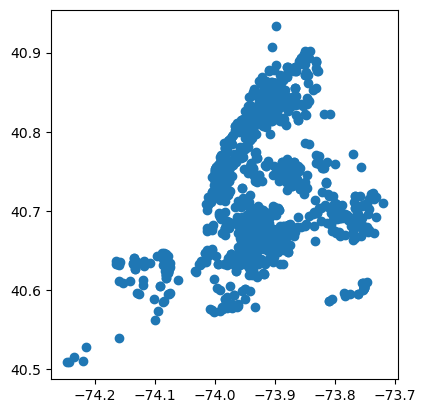

In [18]:
#make fp data geopandas
gdf = gpd.GeoDataFrame(
   df, geometry=gpd.points_from_xy(df.lng,df.lat)) 
gdf=gdf.set_crs(4326)
gdf.plot();


print("Shape of the dataframe: {}".format(gdf.shape))
print("Projection of dataframe: {}".format(gdf.crs))

In [20]:
#import NYC census tract shapefiles 
nyc_CT = gpd.read_file('../geo_files/nyct2020.shp')
print("Shape of the dataframe: {}".format(nyc_CT.shape))
print("Projection of dataframe: {}".format(nyc_CT.crs))


nyc_CT['centroid']=nyc_CT.centroid.to_crs(4326) #project CRS to projected value (not geographic)
nyc_CT=nyc_CT.to_crs(4326)

print("Shape of the dataframe: {}".format(nyc_CT.shape))
print("Projection of dataframe: {}".format(nyc_CT.crs))
nyc_CT['lon'] = nyc_CT.centroid.x
nyc_CT['lat'] = nyc_CT.centroid.y
nyc_CT.head(n=2)

Shape of the dataframe: (2325, 15)
Projection of dataframe: EPSG:2263
Shape of the dataframe: (2325, 16)
Projection of dataframe: EPSG:4326


/var/folders/dc/rd_rd5f134x0lqqtz2cy_9d80000gn/T/ipykernel_82243/130229556.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nyc_CT['lon'] = nyc_CT.centroid.x
/var/folders/dc/rd_rd5f134x0lqqtz2cy_9d80000gn/T/ipykernel_82243/130229556.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nyc_CT['lat'] = nyc_CT.centroid.y


,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape_Leng,Shape_Area,geometry,centroid,lon,lat
0,1,1,Manhattan,000100,1000100,NaN,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,4121,10833.043929,1.843005e+06,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",POINT (-74.04234 40.69567),-74.042339,40.695673
1,2.01,1,Manhattan,000201,1000201,NaN,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,4103,4754.495247,9.723121e+05,"POLYGON ((-73.98450 40.70951, -73.98655 40.709...",POINT (-73.98585 40.71187),-73.985848,40.711868


In [21]:
#uncomment to generate census tract centroid csv
# nyc_CT[['GEOID','geometry']].to_file('~/geo_files/census_tract_borders.geojson',driver='GeoJSON') 
# CT_centroid=nyc_CT[['GEOID','BoroName','NTA2020','lon','lat','centroid']]
# CT_centroid.to_csv('~/geo_files/census_tract_centroid.csv')

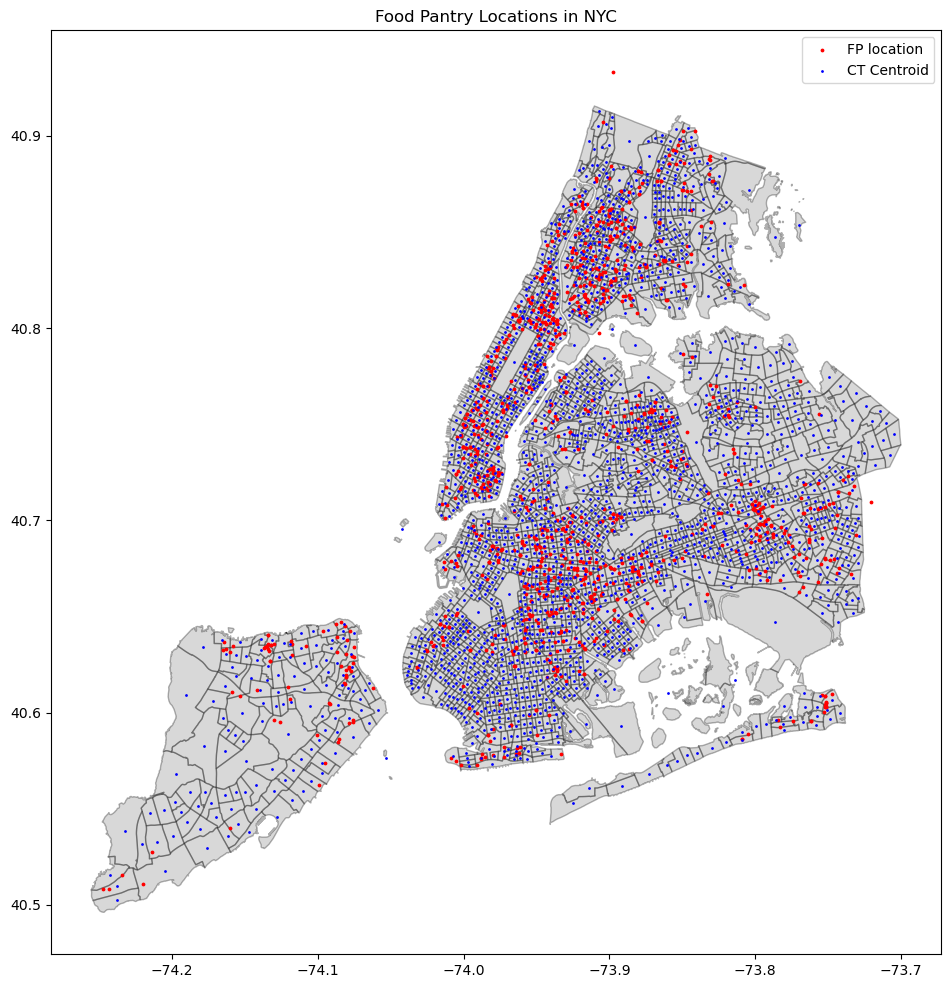

In [22]:
fig,(ax1)=plt.subplots(ncols=(1),nrows=(1),figsize=(12,12))
nyc_CT.plot(ax=ax1,alpha=0.3,color='grey',zorder=1,edgecolor='black');
gdf.plot(ax=ax1,markersize=3,color='red',label='FP location')
nyc_CT['centroid'].plot(ax=ax1,markersize=1,color='blue',label='CT Centroid')
ax1.legend()
ax1.set_title('Food Pantry Locations in NYC');

In [23]:
#add borough and census block group information based on sjoin
fp=gdf.set_crs(4326).sjoin(nyc_CT.drop(columns=['CTLabel', 'BoroCode', 
       'CT2020', 'BoroCT2020', 'CDEligibil', 'NTAName', 'NTA2020', 'CDTA2020', 
        'CDTANAME','PUMA','Shape_Leng', 'Shape_Area', 'centroid', 'lon', 'lat']),how='inner')
fp=fp[['id', 'Name', 'Address', 'Hours FINAL',
       'Hours FPC', 'Hours Plentiful', 'lat', 'lng','Additional Notes', 'BoroName','geometry']]
fp.head()

,id,Name,Address,Hours FINAL,Hours FPC,Hours Plentiful,lat,lng,Additional Notes,BoroName,geometry
0,03f3326e-7b52-4fdb-af71-5bece2b0a088,St. Albans Baptist Church,196-20 119th Ave,"Sa 10:00AM-12:00PM ""every first and third Satu...","Sa 10:00AM-12:00PM ""every first and third Satu...",NaN,40.690698,-73.753923,- Will not refuse anyone even if they don't ha...,Queens,POINT (-73.75392 40.69070)
3,22a2afb1-308b-4083-be89-c7d5902a8b2f,The Center for Family Life,443 39th St,"tu,we,th 01:00PM-04:00PM","tu,we,th 01:00PM-04:00PM",NaN,40.652009,-74.004742,- Vouchers/tickets are only given out to the f...,Brooklyn,POINT (-74.00474 40.65201)
4,369d7a47-7352-4544-b5d7-06197db37f14,Family Services Network of New York,1420 Bushwick Ave,"Mo,We 09:00AM-01:00PM","Mo,We 09:00AM-01:00PM",NaN,40.684120,-73.909235,- Visitors will not be denied if they do not h...,Brooklyn,POINT (-73.90923 40.68412)
5,b1d98238-9b1a-4ab4-9046-2cb06b9baa44,Jamaica Hispanic SDA Church,88-28 161st St,Su 08:00AM-09:00AM,Su 08:00AM-09:00AM,NaN,40.707286,-73.800950,- Visitors will be required to identify how ma...,Queens,POINT (-73.80095 40.70729)
456,c75f21b9-2ab9-454f-92ef-2ce586762aaa,Project New Yorker Corp,169-18 Hillside Avenue,We 10:00AM-01:00PM,We 10:00AM-01:00PM,NaN,40.708391,-73.801949,- Located on the second floor\n- Closed due to...,Queens,POINT (-73.80195 40.70839)


In [24]:
#11% of FPs do not have listed hours 
len(fp[fp['Hours FINAL'].isna()])/len(fp['Hours FINAL'])

0.11038430089942763

In [25]:
#Hours FPC that are null
len(fp[fp['Hours FPC'].isna()])/len(fp['Hours FPC'])

0.22158626328699918

In [26]:
#Hours from Plentiful that are null
len(fp[fp['Hours Plentiful'].isna()])/len(fp['Hours Plentiful'])

0.7808667211774325

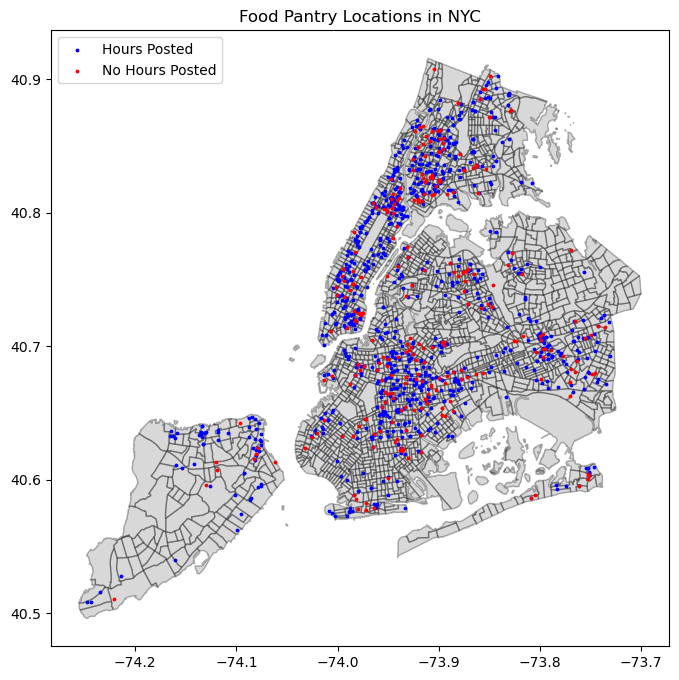

In [27]:
fig,(ax1)=plt.subplots(ncols=(1),nrows=(1),figsize=(8,8))
nyc_CT.plot(ax=ax1,alpha=0.3,color='grey',zorder=1,edgecolor='black');
fp[~fp['Hours FPC'].isna()].plot(ax=ax1,markersize=3,color='blue',label='Hours Posted')
fp[fp['Hours FPC'].isna()].plot(ax=ax1,markersize=3,color='red',label='No Hours Posted')
ax1.legend()
ax1.set_title('Food Pantry Locations in NYC');

In [28]:
fp[fp['Hours FINAL'].isna()]['Additional Notes'].unique()

array([nan,
       '- Visitors line up as early as 6AM\n- Please bring your own bags or cart\n- Vaccination card required with ID',
       'They have events for everybody not just the people within the church.',
       '- Serves the Jewish community in Queens\n- Delivers food on Wednesday nights.  See website for delivery schedule.\n- Kosher food only\n- Have option for cooked food\n- Offers pickup, delivery, or supermarket style',
       '- Open to enrolled students only',
       '- Only serves Khalil Gibran International Academy students\n- Open during school hours',
       '- Participants must register via Plentiful\n- Pantry times vary so check the Plentiful app\n- Visitors must live in the zip code 11368',
       '- Open twice a month normally every other Thursday. To find out when the pantry is open this month, please call.\n- Must register beforehand',
       '- Due to Covid, food pantry open once or twice a month, dependent on volunteer workers ',
       '- Open to everyone\n- 

In [29]:

pattern_dict={'Mo':r"(mo|mo(,|-|, )[a-z, ]*|[a-z, ]*(,|-|, )mo) [0-9]{1,2}.[0-9]{2}(am|pm)-[0-9]{1,2}.[0-9]{2}(am|pm)",
             'Tu':r"(tu|tu(,|-|, )[a-z, ]*|[a-z, ]*(,|-|, )tu) [0-9]{1,2}.[0-9]{2}(am|pm)-[0-9]{1,2}.[0-9]{2}(am|pm)",
             'We':r"(we|we(,|-|, )[a-z, ]*|[a-z, ]*(,|-|, )we) [0-9]{1,2}.[0-9]{2}(am|pm)-[0-9]{1,2}.[0-9]{2}(am|pm)",
             'Th':r"(th|th(,|-|, )[a-z, ]*|[a-z, ]*(,|-|, )th) [0-9]{1,2}.[0-9]{2}(am|pm)-[0-9]{1,2}.[0-9]{2}(am|pm)",
             'Fr':r"(fr|fr(,|-|, )[a-z, ]*|[a-z, ]*(,|-|, )fr) [0-9]{1,2}.[0-9]{2}(am|pm)-[0-9]{1,2}.[0-9]{2}(am|pm)",
             'Sa':r"(sa|sa(,|-|, )[a-z, ]*|[a-z, ]*(,|-|, )sa) [0-9]{1,2}.[0-9]{2}(am|pm)-[0-9]{1,2}.[0-9]{2}(am|pm)",
             'Su':r"(su|su(,|-|, )[a-z, ]*|[a-z, ]*(,|-|, )su) [0-9]{1,2}.[0-9]{2}(am|pm)-[0-9]{1,2}.[0-9]{2}(am|pm)"}

def parse_times(fp,pattern_dict):
    for day in ['Mo','Tu','We','Th','Fr','Sa','Su']:
        start_hours=[]
        end_hours=[]
        note_list=[]

        pattern = pattern_dict[day]
        regEx = re.compile(pattern,re.IGNORECASE)


        for i in range(len(fp['Hours FPC'])): #2022 uses hours final

            open_hours=re.search(regEx, fp.iloc[i,4]) #4 is HOURS FPC

            if open_hours:
    
                pattern_start=r"[0-9]{1,2}:[0-9]{2}(am|pm)-"
                regEx_start = re.compile(pattern_start,re.IGNORECASE)
                t_start=re.search(regEx_start, open_hours.group(0))
                
                if t_start:
                    time_start=round(int(t_start.group(0)[:-6])+int(t_start.group(0)[-5:-3])/60,2)
                    #print('t_start_parsed',t_start.group(0))
                    #print(t_start.group(0)[3:5],int(t_start.group(0)[3:5])/60)

                    if ((t_start.group(0)[:-6]=='12') & (t_start.group(0)[-3:-1]=='AM')):#t_start.group(0)=='-12:00AM':
                            time_start-=12

                    if t_start.group(1)=='PM':

                        if ((t_start.group(0)[:-6]!='12') & (t_start.group(0)[-3:-1]=='PM')):#t_start.group(0)!='-12:00PM':
                            time_start+=12

                    start_hours.append(time_start)
                else:
                    start_hours.append(None)
                #print('processed',time_start)

                pattern_end=r"-[0-9]{1,2}:[0-9]{2}(am|pm)"
                regEx_end = re.compile(pattern_end,re.IGNORECASE)

                t_end=re.search(regEx_end, open_hours.group(0))

                if t_end:
                    #print('t_end_parsed',   )
                    #print(t_end.group(0))
                    time_end=round(int(t_end.group(0)[1:-5])+int(t_end.group(0)[-4:-2])/60,2)
                    if ((t_end.group(0)[1:-5]=='12') & (t_end.group(0)[-2:]=='AM')):
                            time_end-=12
                    if t_end.group(1)=='PM':

                        if ((t_end.group(0)[1:-5]!='12') & (t_end.group(0)[-2:]=='PM')):#t_end.group(0)!='-12:00PM':
                            time_end+=12
                    #print('processed',time_end)
                    end_hours.append(time_end)

                else:
                    end_hours.append(None)
            else:
                start_hours.append(None)
                end_hours.append(None)

            pattern_notes=r"\".*\"" #this grabs notes, most notes are enclsoed in quotations
            regEx_notes = re.compile(pattern_notes,re.IGNORECASE)
            notes=re.search(regEx_notes, fp.iloc[i,4])
            if notes:
                note_list.append(notes.group(0))
            else:
                note_list.append(None)




        fp[day+'_open']=start_hours       
        fp[day+'_close']=end_hours 
        fp['notes']=note_list
    return fp


In [30]:
#Change to string so we can flag it
fp=fp[~fp['Hours FPC'].isna()] #drop all null values 
#fp.loc[fp['Hours FPC'].isna(),'Hours FPC']='None'
fp=parse_times(fp,pattern_dict) # parse hours to open and close times
fp.head(n=20)

,id,Name,Address,Hours FINAL,Hours FPC,Hours Plentiful,lat,lng,Additional Notes,BoroName,...,We_open,We_close,Th_open,Th_close,Fr_open,Fr_close,Sa_open,Sa_close,Su_open,Su_close
0,03f3326e-7b52-4fdb-af71-5bece2b0a088,St. Albans Baptist Church,196-20 119th Ave,"Sa 10:00AM-12:00PM ""every first and third Satu...","Sa 10:00AM-12:00PM ""every first and third Satu...",NaN,40.690698,-73.753923,- Will not refuse anyone even if they don't ha...,Queens,...,NaN,NaN,NaN,NaN,NaN,NaN,10.0,12.0,NaN,NaN
3,22a2afb1-308b-4083-be89-c7d5902a8b2f,The Center for Family Life,443 39th St,"tu,we,th 01:00PM-04:00PM","tu,we,th 01:00PM-04:00PM",NaN,40.652009,-74.004742,- Vouchers/tickets are only given out to the f...,Brooklyn,...,13.0,16.0,13.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN
4,369d7a47-7352-4544-b5d7-06197db37f14,Family Services Network of New York,1420 Bushwick Ave,"Mo,We 09:00AM-01:00PM","Mo,We 09:00AM-01:00PM",NaN,40.684120,-73.909235,- Visitors will not be denied if they do not h...,Brooklyn,...,9.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,b1d98238-9b1a-4ab4-9046-2cb06b9baa44,Jamaica Hispanic SDA Church,88-28 161st St,Su 08:00AM-09:00AM,Su 08:00AM-09:00AM,NaN,40.707286,-73.800950,- Visitors will be required to identify how ma...,Queens,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,9.0
456,c75f21b9-2ab9-454f-92ef-2ce586762aaa,Project New Yorker Corp,169-18 Hillside Avenue,We 10:00AM-01:00PM,We 10:00AM-01:00PM,NaN,40.708391,-73.801949,- Located on the second floor\n- Closed due to...,Queens,...,10.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
494,612ecd35-331b-4a16-917b-94565ec46224,Jamaica Seventh Day Adventist Church,88-28 163rd St,2023-07-16 09:30AM-11:30AM\n2023-07-23 09:30AM...,Su 09:30AM-11:30AM,2023-07-16 09:30AM-11:30AM\n2023-07-23 09:30AM...,40.707826,-73.799020,- ID required for the first visit\n- Please br...,Queens,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.5,11.5
513,56170843-6904-4c0b-9d00-69bf6f14e7d8,First United Methodist Church of Jamaica,162-10 Highland Ave,2023-07-17 08:30AM-09:30AM\n2023-07-20 06:00PM...,Mo 08:30AM-09:30AM\nTh 06:00PM-07:00PM,2023-07-17 08:30AM-09:30AM\n2023-07-20 06:00PM...,40.709872,-73.800052,- ID is required for first-timers. Participant...,Queens,...,NaN,NaN,18.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN
775,b2385fe0-e936-4d64-a63e-6109d681aa02,"Catholic Charities Brooklyn and Queens, Presen...",88-19 Parsons Blvd,2023-07-18 04:00PM-06:00PM\n2023-07-25 04:00PM...,Th 05:30PM-06:30PM,2023-07-18 04:00PM-06:00PM\n2023-07-25 04:00PM...,40.706113,-73.801332,- Opens at 5:30PM and closes when food runs o...,Queens,...,NaN,NaN,17.5,18.5,NaN,NaN,NaN,NaN,NaN,NaN
1072,fca97966-5eff-471d-854d-aa2dd88a86c0,"Catholic Charities Brooklyn and Queens, Presen...",88-19 Parsons Blvd,"We 04:00PM-06:00PM\n""every first and third Wed...","We 04:00PM-06:00PM\n""every first and third Wed...",NaN,40.706113,-73.801332,NaN,Queens,...,16.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,c0a0e9c6-11ce-4094-98a1-e16e1a5f32c3,New York City Love Kitchen - Food Pantry,3816 9th Ave,"We 11:00AM-12:00PM ""1st and 3rd Wednesday of t...","We 11:00AM-12:00PM ""1st and 3rd Wednesday of t...",NaN,40.862233,-73.918484,- Visitors need to call to register before arr...,Manhattan,...,11.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
#spot check
fp.iloc[4]

id                               c75f21b9-2ab9-454f-92ef-2ce586762aaa
Name                                          Project New Yorker Corp
Address                                        169-18 Hillside Avenue
Hours FINAL                                        We 10:00AM-01:00PM
Hours FPC                                          We 10:00AM-01:00PM
Hours Plentiful                                                   NaN
lat                                                         40.708391
lng                                                        -73.801949
Additional Notes    - Located on the second floor\n- Closed due to...
BoroName                                                       Queens
geometry                              POINT (-73.80194932 40.7083915)
Mo_open                                                           NaN
Mo_close                                                          NaN
notes                                                            None
Tu_open             

In [32]:
#all food pantries where no hours are parsed
fp_faulty_hours=fp.drop(index=fp[['Mo_open', 'Mo_close',
       'Tu_open', 'Tu_close', 'We_open', 'We_close', 'Th_open', 'Th_close',
       'Fr_open', 'Fr_close', 'Sa_open', 'Sa_close', 'Su_open', 'Su_close']].dropna(how='all').index)


fp_faulty_hours

,id,Name,Address,Hours FINAL,Hours FPC,Hours Plentiful,lat,lng,Additional Notes,BoroName,...,We_open,We_close,Th_open,Th_close,Fr_open,Fr_close,Sa_open,Sa_close,Su_open,Su_close
424,01776d97-82e2-4625-b14d-9014e4fc1782,Vision Urbana,64 Essex St,2023-07-17 09:00AM-11:00AM\n2023-07-24 09:00AM...,"Mo,Tu 09:00AM–12:00PM\n",2023-07-17 09:00AM-11:00AM\n2023-07-24 09:00AM...,40.717340,-73.988424,- Monday open to the public\n- Mostly door-to-...,Manhattan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,668e409f-e764-4514-8b2b-7f6745a1af53,"Momentum Project, St. Peter's Church",619 Lexington Ave,"mo,tu,we,th,fr,sa,su 08:30 AM-08:00 PM","mo,tu,we,th,fr,sa,su 08:30 AM-08:00 PM",NaN,40.758565,-73.970383,- Temporarily closed until further notice due ...,Manhattan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,34a5da0a-e591-4dcd-93d6-4570d7da0343,Greater Bethel Community Development,95-26 Sutphin Blvd,Start from March 1st,Start from March 1st,NaN,40.697806,-73.806377,- The food pantry operates in the parking lot ...,Queens,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,c76a4106-1cd9-483c-abdc-1efb91f58d99,Blessed Sacrament Church - Soup Kitchen,152 W 71st St,Su 02:00PM,Su 02:00PM,NaN,40.777410,-73.981242,- Soup kitchen ends when the line ends.,Manhattan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1141,01a9e3ab-f68b-463d-a9d8-8f731a842386,Church of God in Christ on the Hill - Soup Kit...,137 Buffalo Ave,Fr 12:30PM,Fr 12:30PM,NaN,40.674546,-73.924639,NaN,Brooklyn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
239,6c9f0d27-9460-4ac7-b984-f6552bd4f58f,St. Ignatius Episcopal Church,552 West End Ave,Sa 04:00PM\nMo 07:00PM,Sa 04:00PM\nMo 07:00PM,NaN,40.789250,-73.977080,- Please arrive 15 minutes early\n- Serving to...,Manhattan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
323,61662bb7-dfa4-454a-ac6c-ba38eea72ea8,Missionaries of Charity - Harlem,406 W 127th St,"Su-We,Fr,Sa 09:30AM","Su-We,Fr,Sa 09:30AM",NaN,40.812800,-73.953630,- Open to everyone,Manhattan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
461,fd14be9b-afba-4bde-a11e-5aae055ee5d0,Community Impact - Soup Kitchen,601 W 114 St,2023-07-17 11:00AM-02:00PM\n2023-07-19 11:00AM...,"Mo,We,Fr 10:00AM\n",2023-07-17 11:00AM-02:00PM\n2023-07-19 11:00AM...,40.807135,-73.965897,- Located in the basement\n- Dine in or grab &...,Manhattan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253,f7f5cfaf-698d-4f42-b589-7e391706651e,Richmond Hill SDA Community Service,114-08 Jamaica Ave,Saturdays 09:15AM- 01:00AM,Saturdays 09:15AM- 01:00AM,NaN,40.698344,-73.834506,- Pantry times vary. Call to confirm the next ...,Queens,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
534,d9dfbd3f-1e08-4917-9993-075c1e15df18,"Cienfuegos, Bronx",482 E 138th St,Tu 01:00PM,Tu 01:00PM,NaN,40.766658,-73.930089,- Home delivery available for COVID-19 patient...,Queens,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
print('Total # Food pantries:',len(fp))
print('Total # Food pantries with hours:',len(fp[['Mo_open', 'Mo_close',
       'Tu_open', 'Tu_close', 'We_open', 'We_close', 'Th_open', 'Th_close',
       'Fr_open', 'Fr_close', 'Sa_open', 'Sa_close', 'Su_open', 'Su_close']].dropna(how='all')))
print('Total # Food pantries without hours:',len(fp_faulty_hours))
print('Percentage without posted hours: ',round((len(fp_faulty_hours)/len(fp))*100,1),'%' )

Total # Food pantries: 952
Total # Food pantries with hours: 913
Total # Food pantries without hours: 39
Percentage without posted hours:  4.1 %


In [34]:
fp['Hours_parsed']=1
fp.loc[fp['id'].isin(list(fp_faulty_hours.id)),'Hours_parsed']=0

In [35]:
fp[fp['Hours_parsed']==0]

,id,Name,Address,Hours FINAL,Hours FPC,Hours Plentiful,lat,lng,Additional Notes,BoroName,...,We_close,Th_open,Th_close,Fr_open,Fr_close,Sa_open,Sa_close,Su_open,Su_close,Hours_parsed
424,01776d97-82e2-4625-b14d-9014e4fc1782,Vision Urbana,64 Essex St,2023-07-17 09:00AM-11:00AM\n2023-07-24 09:00AM...,"Mo,Tu 09:00AM–12:00PM\n",2023-07-17 09:00AM-11:00AM\n2023-07-24 09:00AM...,40.717340,-73.988424,- Monday open to the public\n- Mostly door-to-...,Manhattan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
69,668e409f-e764-4514-8b2b-7f6745a1af53,"Momentum Project, St. Peter's Church",619 Lexington Ave,"mo,tu,we,th,fr,sa,su 08:30 AM-08:00 PM","mo,tu,we,th,fr,sa,su 08:30 AM-08:00 PM",NaN,40.758565,-73.970383,- Temporarily closed until further notice due ...,Manhattan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
45,34a5da0a-e591-4dcd-93d6-4570d7da0343,Greater Bethel Community Development,95-26 Sutphin Blvd,Start from March 1st,Start from March 1st,NaN,40.697806,-73.806377,- The food pantry operates in the parking lot ...,Queens,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
107,c76a4106-1cd9-483c-abdc-1efb91f58d99,Blessed Sacrament Church - Soup Kitchen,152 W 71st St,Su 02:00PM,Su 02:00PM,NaN,40.777410,-73.981242,- Soup kitchen ends when the line ends.,Manhattan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1141,01a9e3ab-f68b-463d-a9d8-8f731a842386,Church of God in Christ on the Hill - Soup Kit...,137 Buffalo Ave,Fr 12:30PM,Fr 12:30PM,NaN,40.674546,-73.924639,NaN,Brooklyn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
239,6c9f0d27-9460-4ac7-b984-f6552bd4f58f,St. Ignatius Episcopal Church,552 West End Ave,Sa 04:00PM\nMo 07:00PM,Sa 04:00PM\nMo 07:00PM,NaN,40.789250,-73.977080,- Please arrive 15 minutes early\n- Serving to...,Manhattan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
323,61662bb7-dfa4-454a-ac6c-ba38eea72ea8,Missionaries of Charity - Harlem,406 W 127th St,"Su-We,Fr,Sa 09:30AM","Su-We,Fr,Sa 09:30AM",NaN,40.812800,-73.953630,- Open to everyone,Manhattan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
461,fd14be9b-afba-4bde-a11e-5aae055ee5d0,Community Impact - Soup Kitchen,601 W 114 St,2023-07-17 11:00AM-02:00PM\n2023-07-19 11:00AM...,"Mo,We,Fr 10:00AM\n",2023-07-17 11:00AM-02:00PM\n2023-07-19 11:00AM...,40.807135,-73.965897,- Located in the basement\n- Dine in or grab &...,Manhattan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
253,f7f5cfaf-698d-4f42-b589-7e391706651e,Richmond Hill SDA Community Service,114-08 Jamaica Ave,Saturdays 09:15AM- 01:00AM,Saturdays 09:15AM- 01:00AM,NaN,40.698344,-73.834506,- Pantry times vary. Call to confirm the next ...,Queens,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
534,d9dfbd3f-1e08-4917-9993-075c1e15df18,"Cienfuegos, Bronx",482 E 138th St,Tu 01:00PM,Tu 01:00PM,NaN,40.766658,-73.930089,- Home delivery available for COVID-19 patient...,Queens,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [36]:
#fp_faulty_hours.to_csv('fp_faulty_hours.csv')
#fp.to_csv("food_pantry_schedule.csv")

In [38]:
fp_adjusted_hours=pd.read_csv('2023_fp_faulty_hours_updated.csv',index_col=0) #import in dataset that manually entered some of the missing hours
#fp_adjusted_hours=fp_adjusted_hours[fp_adjusted_hours['Adjusted']==1.0]
fp_adjusted_hours=parse_times(fp_adjusted_hours,pattern_dict)
#fp_adjusted_hours.drop(columns=['Adjusted','Website or Notes','notes'],inplace=True)
fp_adjusted_hours.head()

,id,Name,Address,Hours FINAL,Hours FPC,Hours Plentiful,lat,lng,Additional Notes,BoroName,...,We_open,We_close,Th_open,Th_close,Fr_open,Fr_close,Sa_open,Sa_close,Su_open,Su_close
424,01776d97-82e2-4625-b14d-9014e4fc1782,Vision Urbana,64 Essex St,2023-07-17 09:00AM-11:00AM\n2023-07-24 09:00AM...,"Mo,Tu 09:00AM-12:00PM\n",2023-07-17 09:00AM-11:00AM\n2023-07-24 09:00AM...,40.717340,-73.988424,- Monday open to the public\n- Mostly door-to-...,Manhattan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,668e409f-e764-4514-8b2b-7f6745a1af53,"Momentum Project, St. Peter's Church",619 Lexington Ave,"mo,tu,we,th,fr,sa,su 08:30 AM-08:00 PM","mo,tu,we,th,fr,sa,su 08:30AM-08:00PM",NaN,40.758565,-73.970383,- Temporarily closed until further notice due ...,Manhattan,...,8.5,20.0,8.5,20.0,8.5,20.0,8.5,20.0,8.5,20.0
45,34a5da0a-e591-4dcd-93d6-4570d7da0343,Greater Bethel Community Development,95-26 Sutphin Blvd,Start from March 1st,Start from March 1st,NaN,40.697806,-73.806377,- The food pantry operates in the parking lot ...,Queens,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,c76a4106-1cd9-483c-abdc-1efb91f58d99,Blessed Sacrament Church - Soup Kitchen,152 W 71st St,Su 02:00PM,Su 02:00PM-03:00PM,NaN,40.777410,-73.981242,- Soup kitchen ends when the line ends.,Manhattan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,15.0
1141,01a9e3ab-f68b-463d-a9d8-8f731a842386,Church of God in Christ on the Hill - Soup Kit...,137 Buffalo Ave,Fr 12:30PM,Fr 12:30PM-01:30PM,NaN,40.674546,-73.924639,NaN,Brooklyn,...,NaN,NaN,NaN,NaN,12.5,13.5,NaN,NaN,NaN,NaN


In [39]:
fp_adjusted_hours.drop(index=fp_adjusted_hours[['Mo_open', 'Mo_close',
       'Tu_open', 'Tu_close', 'We_open', 'We_close', 'Th_open', 'Th_close',
       'Fr_open', 'Fr_close', 'Sa_open', 'Sa_close', 'Su_open', 'Su_close']].dropna(how='all').index)



,id,Name,Address,Hours FINAL,Hours FPC,Hours Plentiful,lat,lng,Additional Notes,BoroName,...,We_open,We_close,Th_open,Th_close,Fr_open,Fr_close,Sa_open,Sa_close,Su_open,Su_close
45,34a5da0a-e591-4dcd-93d6-4570d7da0343,Greater Bethel Community Development,95-26 Sutphin Blvd,Start from March 1st,Start from March 1st,NaN,40.697806,-73.806377,- The food pantry operates in the parking lot ...,Queens,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
874,8c3d1a6f-2694-4b89-a1fa-a990b1db9c2d,"Catholic Charities Brooklyn and Queens, St. Gr...",244 Brooklyn Ave,"Every other week and 4/6, 4/20, 5/4, 5/18 : 12...","Every other week and 4/6, 4/20, 5/4, 5/18 : 12...",NaN,40.671854,-73.944888,NaN,Brooklyn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
#combine manually adjusted data with rest 
fp_final=pd.concat([fp[fp['Hours_parsed']==1],fp_adjusted_hours],axis=0)
fp_final

,id,Name,Address,Hours FINAL,Hours FPC,Hours Plentiful,lat,lng,Additional Notes,BoroName,...,We_close,Th_open,Th_close,Fr_open,Fr_close,Sa_open,Sa_close,Su_open,Su_close,Hours_parsed
0,03f3326e-7b52-4fdb-af71-5bece2b0a088,St. Albans Baptist Church,196-20 119th Ave,"Sa 10:00AM-12:00PM ""every first and third Satu...","Sa 10:00AM-12:00PM ""every first and third Satu...",NaN,40.690698,-73.753923,- Will not refuse anyone even if they don't ha...,Queens,...,NaN,NaN,NaN,NaN,NaN,10.0,12.0,NaN,NaN,1.0
3,22a2afb1-308b-4083-be89-c7d5902a8b2f,The Center for Family Life,443 39th St,"tu,we,th 01:00PM-04:00PM","tu,we,th 01:00PM-04:00PM",NaN,40.652009,-74.004742,- Vouchers/tickets are only given out to the f...,Brooklyn,...,16.0,13.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,369d7a47-7352-4544-b5d7-06197db37f14,Family Services Network of New York,1420 Bushwick Ave,"Mo,We 09:00AM-01:00PM","Mo,We 09:00AM-01:00PM",NaN,40.684120,-73.909235,- Visitors will not be denied if they do not h...,Brooklyn,...,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,b1d98238-9b1a-4ab4-9046-2cb06b9baa44,Jamaica Hispanic SDA Church,88-28 161st St,Su 08:00AM-09:00AM,Su 08:00AM-09:00AM,NaN,40.707286,-73.800950,- Visitors will be required to identify how ma...,Queens,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,9.0,1.0
456,c75f21b9-2ab9-454f-92ef-2ce586762aaa,Project New Yorker Corp,169-18 Hillside Avenue,We 10:00AM-01:00PM,We 10:00AM-01:00PM,NaN,40.708391,-73.801949,- Located on the second floor\n- Closed due to...,Queens,...,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,c5743843-df72-4420-858e-d4e4976f760e,St. Paul's Evangelical Lutheran Church,1891 McGraw Ave,2023-07-14 08:00AM-10:00AM\n2023-07-21 08:00AM...,Fr 8:00AM-10:00PM,2023-07-14 08:00AM-10:00AM\n2023-07-21 08:00AM...,40.834644,-73.862352,NaN,Bronx,...,NaN,NaN,NaN,8.0,22.0,NaN,NaN,NaN,NaN,NaN
1073,6568870c-e965-4434-9dee-169d7f22fa5a,"Catholic Charities Brooklyn and Queens, St. Ch...",19 Sidney Pl,2023-07-20 08:30AM-01:00PM\n2023-07-27 08:30AM...,Th 08:30AM-9:30AM,2023-07-20 08:30AM-01:00PM\n2023-07-27 08:30AM...,40.692826,-73.991774,NaN,Brooklyn,...,NaN,8.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1149,cfdea33a-5d79-4beb-8cbb-2c8e96a5462b,"La Jornada, Somos Bendecidos para Bendecir",37-20 111th St,Tu 09:00AM,Tu 09:00AM-10:00AM,NaN,40.753988,-73.857291,NaN,Queens,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1194,0a89964c-eed1-425d-97d9-7d251c834192,"ICNA Relief, Bronx",1965 Edenwald Ave,Sa 09:00AM,Sa 09:00AM-10:00AM,NaN,40.893220,-73.843880,NaN,Bronx,...,NaN,NaN,NaN,NaN,NaN,9.0,10.0,NaN,NaN,NaN


In [41]:
print(len(fp_final))
pattern_=r"soup kitchen"
regEx_ = re.compile(pattern_,re.IGNORECASE)
is_soup_kitchen_list=[]
count=0

for i in range(len(fp_final.Name.values)):
    is_soup_kitchen=re.search(regEx_, fp_final.Name.values[i])
    
    if is_soup_kitchen!=None:
        count=count+1
        
        is_soup_kitchen_list.append(1)
    else:
        count=count+1
        is_soup_kitchen_list.append(0)
        

fp_final['is_soup_kitchen']=is_soup_kitchen_list
fp_final[fp_final['is_soup_kitchen']==1]['Name'].unique()

952


array(['Catholic Charities Brooklyn and Queens, Presentation of the Blessed Virgin Mary - Soup Kitchen',
       'New York City Love Kitchen - Soup Kitchen',
       'Holy Cross, St. John the Baptist, Crossroads - Soup Kitchen',
       'Salvation Army, Bushwick Corps - Soup Kitchen',
       'Thurston Memorial Outreach Ministries - Soup Kitchen',
       'Thessalonia Baptist Church - Soup Kitchen',
       'Masbia of Rego Park - Soup Kitchen',
       'Salem United Methodist Church - Soup Kitchen',
       'Project Hospitality, Faith United Methodist Church - Soup Kitchen',
       "Isaiah's Temple of Mt. Hope - Soup Kitchen",
       'Broadway Community - Soup Kitchen',
       'Salvation Army, Manhattan Citadel Corps - Soup Kitchen',
       'New York City Relief, South Bronx - Soup Kitchen',
       'New York City Relief, Chelsea Park - Mobile Soup Kitchen',
       'New York City Relief, Chelsea Park - Soup Kitchen',
       'Holy Apostles - Soup Kitchen',
       "St. Bartholomew's Community Min

In [42]:
 #drops all entries that are soup kitchen not pantries
fp_final=fp_final[fp_final['is_soup_kitchen']==0]
fp_final.drop(columns='is_soup_kitchen',inplace=True)

/var/folders/dc/rd_rd5f134x0lqqtz2cy_9d80000gn/T/ipykernel_82243/4121619696.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fp_final.drop(columns='is_soup_kitchen',inplace=True)


In [45]:

fp_final['hours_open']=fp_final[['Mo_open', 'Mo_close','Tu_open', 'Tu_close', 'We_open', 'We_close', 'Th_open',
       'Th_close', 'Fr_open', 'Fr_close', 'Sa_open', 'Sa_close', 'Su_open',
       'Su_close']].diff(axis=1)[[ 'Mo_close', 'Tu_close',  'We_close', 
       'Th_close', 'Fr_close', 'Sa_close','Su_close']].sum(axis=1)
fp_final

/var/folders/dc/rd_rd5f134x0lqqtz2cy_9d80000gn/T/ipykernel_82243/1069183002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fp_final['hours_open']=fp_final[['Mo_open', 'Mo_close','Tu_open', 'Tu_close', 'We_open', 'We_close', 'Th_open',


,id,Name,Address,Hours FINAL,Hours FPC,Hours Plentiful,lat,lng,Additional Notes,BoroName,...,Th_open,Th_close,Fr_open,Fr_close,Sa_open,Sa_close,Su_open,Su_close,Hours_parsed,hours_open
0,03f3326e-7b52-4fdb-af71-5bece2b0a088,St. Albans Baptist Church,196-20 119th Ave,"Sa 10:00AM-12:00PM ""every first and third Satu...","Sa 10:00AM-12:00PM ""every first and third Satu...",NaN,40.690698,-73.753923,- Will not refuse anyone even if they don't ha...,Queens,...,NaN,NaN,NaN,NaN,10.0,12.0,NaN,NaN,1.0,2.0
3,22a2afb1-308b-4083-be89-c7d5902a8b2f,The Center for Family Life,443 39th St,"tu,we,th 01:00PM-04:00PM","tu,we,th 01:00PM-04:00PM",NaN,40.652009,-74.004742,- Vouchers/tickets are only given out to the f...,Brooklyn,...,13.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,9.0
4,369d7a47-7352-4544-b5d7-06197db37f14,Family Services Network of New York,1420 Bushwick Ave,"Mo,We 09:00AM-01:00PM","Mo,We 09:00AM-01:00PM",NaN,40.684120,-73.909235,- Visitors will not be denied if they do not h...,Brooklyn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,8.0
5,b1d98238-9b1a-4ab4-9046-2cb06b9baa44,Jamaica Hispanic SDA Church,88-28 161st St,Su 08:00AM-09:00AM,Su 08:00AM-09:00AM,NaN,40.707286,-73.800950,- Visitors will be required to identify how ma...,Queens,...,NaN,NaN,NaN,NaN,NaN,NaN,8.0,9.0,1.0,1.0
456,c75f21b9-2ab9-454f-92ef-2ce586762aaa,Project New Yorker Corp,169-18 Hillside Avenue,We 10:00AM-01:00PM,We 10:00AM-01:00PM,NaN,40.708391,-73.801949,- Located on the second floor\n- Closed due to...,Queens,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,c5743843-df72-4420-858e-d4e4976f760e,St. Paul's Evangelical Lutheran Church,1891 McGraw Ave,2023-07-14 08:00AM-10:00AM\n2023-07-21 08:00AM...,Fr 8:00AM-10:00PM,2023-07-14 08:00AM-10:00AM\n2023-07-21 08:00AM...,40.834644,-73.862352,NaN,Bronx,...,NaN,NaN,8.0,22.0,NaN,NaN,NaN,NaN,NaN,14.0
1073,6568870c-e965-4434-9dee-169d7f22fa5a,"Catholic Charities Brooklyn and Queens, St. Ch...",19 Sidney Pl,2023-07-20 08:30AM-01:00PM\n2023-07-27 08:30AM...,Th 08:30AM-9:30AM,2023-07-20 08:30AM-01:00PM\n2023-07-27 08:30AM...,40.692826,-73.991774,NaN,Brooklyn,...,8.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1149,cfdea33a-5d79-4beb-8cbb-2c8e96a5462b,"La Jornada, Somos Bendecidos para Bendecir",37-20 111th St,Tu 09:00AM,Tu 09:00AM-10:00AM,NaN,40.753988,-73.857291,NaN,Queens,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1194,0a89964c-eed1-425d-97d9-7d251c834192,"ICNA Relief, Bronx",1965 Edenwald Ave,Sa 09:00AM,Sa 09:00AM-10:00AM,NaN,40.893220,-73.843880,NaN,Bronx,...,NaN,NaN,NaN,NaN,9.0,10.0,NaN,NaN,NaN,1.0


In [50]:
#drop 2 CTS with no parseable horus
fp_final.dropna(subset=['Mo_open', 'Mo_close','Tu_open', 'Tu_close', 'We_open', 'We_close', 'Th_open',
    'Th_close', 'Fr_open', 'Fr_close', 'Sa_open', 'Sa_close', 'Su_open',
       'Su_close'],how='all',inplace=True)

/var/folders/dc/rd_rd5f134x0lqqtz2cy_9d80000gn/T/ipykernel_82243/1162205932.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fp_final.dropna(subset=['Mo_open', 'Mo_close','Tu_open', 'Tu_close', 'We_open', 'We_close', 'Th_open',


In [51]:
fp_final.hours_open.median()

3.0

In [52]:
def create_hour_list(start,end):

    return list(range(int(np.floor(start)),int(np.ceil(end))))
    

,id,Mo_open,Mo_close,open_hours
949,ee7c1113-ef78-4bc6-bf7e-7069e918785e,0.0,23.75,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


,id,Mo_open,Mo_close,open_hours
949,ee7c1113-ef78-4bc6-bf7e-7069e918785e,0.0,23.75,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
670,8496d7e2-ba24-4622-85df-14ae3d6d7198,11.0,22.00,"[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]"
1085,a6486eff-4404-4be5-b19d-9569886e8730,9.0,23.50,"[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20..."


,id,Tu_open,Tu_close,open_hours
949,ee7c1113-ef78-4bc6-bf7e-7069e918785e,0.0,23.75,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


,id,Tu_open,Tu_close,open_hours
242,b8ca803d-88b5-441f-ac75-be669574acf4,9.0,23.00,"[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20..."
949,ee7c1113-ef78-4bc6-bf7e-7069e918785e,0.0,23.75,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
246,929c1e8b-07a7-4cc4-9a1e-2118020c5b9b,9.0,22.50,"[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20..."
670,8496d7e2-ba24-4622-85df-14ae3d6d7198,11.0,22.00,"[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]"
836,5483b9a2-b0b6-48e4-89e5-10d8cdda27ed,10.0,23.50,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2..."


,id,We_open,We_close,open_hours
949,ee7c1113-ef78-4bc6-bf7e-7069e918785e,0.0,23.75,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


,id,We_open,We_close,open_hours
949,ee7c1113-ef78-4bc6-bf7e-7069e918785e,0.0,23.75,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
173,5296704f-337c-4a1f-8a80-509431a39adc,9.5,23.50,"[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20..."
265,879eab66-b34f-4caa-acca-3141e44bd29e,9.5,23.50,"[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20..."
670,8496d7e2-ba24-4622-85df-14ae3d6d7198,11.0,22.00,"[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]"
465,5479006b-8ef9-41f3-962a-a72dfc1c5195,10.0,23.00,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2..."
1085,a6486eff-4404-4be5-b19d-9569886e8730,9.0,23.50,"[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20..."
947,ed799a19-e025-4897-ab1c-bd646d5fae3f,9.0,23.50,"[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20..."


,id,Th_open,Th_close,open_hours
949,ee7c1113-ef78-4bc6-bf7e-7069e918785e,0.0,23.75,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


,id,Th_open,Th_close,open_hours
949,ee7c1113-ef78-4bc6-bf7e-7069e918785e,0.0,23.75,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
670,8496d7e2-ba24-4622-85df-14ae3d6d7198,11.0,22.00,"[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]"
1085,a6486eff-4404-4be5-b19d-9569886e8730,9.0,23.50,"[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20..."


,id,Fr_open,Fr_close,open_hours
949,ee7c1113-ef78-4bc6-bf7e-7069e918785e,0.0,23.75,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


,id,Fr_open,Fr_close,open_hours
949,ee7c1113-ef78-4bc6-bf7e-7069e918785e,0.0,23.75,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
56,6cd815ca-f1d1-4d12-ac4e-87b506809b74,9.5,22.50,"[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20..."
670,8496d7e2-ba24-4622-85df-14ae3d6d7198,11.0,22.00,"[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]"
410,d4867935-bf69-49ba-8281-216955d0dc30,9.0,23.00,"[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20..."
1062,c5743843-df72-4420-858e-d4e4976f760e,8.0,22.00,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,..."


,id,Sa_open,Sa_close,open_hours
949,ee7c1113-ef78-4bc6-bf7e-7069e918785e,0.0,23.75,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


,id,Sa_open,Sa_close,open_hours
949,ee7c1113-ef78-4bc6-bf7e-7069e918785e,0.0,23.75,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
382,5acb41b2-7d5a-43fa-be57-86c29849672e,10.0,23.50,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2..."
173,5296704f-337c-4a1f-8a80-509431a39adc,9.5,23.50,"[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20..."
265,879eab66-b34f-4caa-acca-3141e44bd29e,9.5,23.50,"[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20..."
630,a8a66362-9a6b-46af-a7cd-e6c4c414c3dc,10.0,23.50,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2..."
947,ed799a19-e025-4897-ab1c-bd646d5fae3f,9.0,23.50,"[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20..."


,id,Su_open,Su_close,open_hours
949,ee7c1113-ef78-4bc6-bf7e-7069e918785e,0.0,23.75,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


,id,Su_open,Su_close,open_hours
949,ee7c1113-ef78-4bc6-bf7e-7069e918785e,0.0,23.75,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


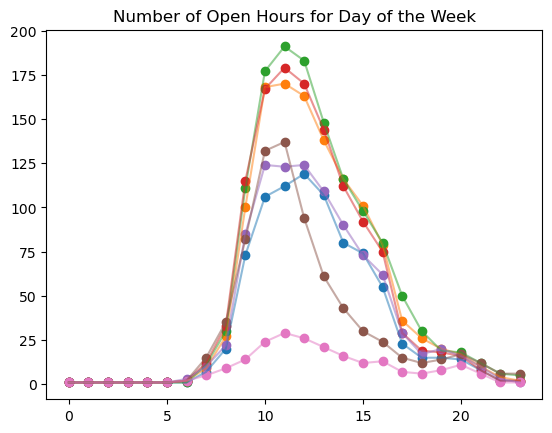

In [53]:
for day in ['Mo','Tu','We','Th','Fr','Sa','Su']:
    df_hours=fp_final[['id',day+'_open',day+'_close']].dropna(subset=[day+'_open',day+'_close'])
    df_hours['open_hours']=df_hours.apply(lambda x: create_hour_list(x[day+'_open'],x[day+'_close']), axis=1)
    display(df_hours[df_hours[day+'_open']<6])
    display(df_hours[df_hours[day+'_close']>=22])

    
    h_list=[]
    for i in df_hours['open_hours'].values:
        h_list+=i
    if day=='Mo':
        df_hour_count=pd.DataFrame.from_dict(Counter(h_list),orient='index',columns=[day+'_count']).sort_index()
    else:
        df_hour_count=df_hour_count.merge(pd.DataFrame.from_dict(Counter(h_list),orient='index',columns=[day+'_count']).sort_index(),left_index=True,right_index=True)
    
    plt.scatter(df_hour_count.index,df_hour_count[day+'_count'])
    plt.plot(df_hour_count.index,df_hour_count[day+'_count'],alpha=0.5)

    plt.title('Number of Open Hours for Day of the Week')
    #plt.show();

<Axes: >

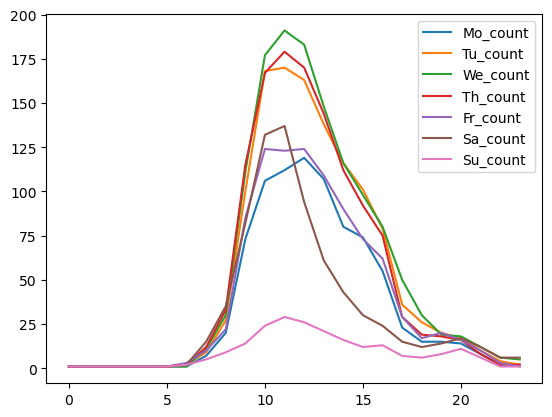

In [56]:
df_hour_count.plot()

In [58]:
gdf_final = gpd.GeoDataFrame(
      fp_final, geometry=gpd.points_from_xy(fp_final.lng, fp_final.lat))
# gdf_final.to_file("food_pantry_schedule_final.geojson",  driver="GeoJSON")

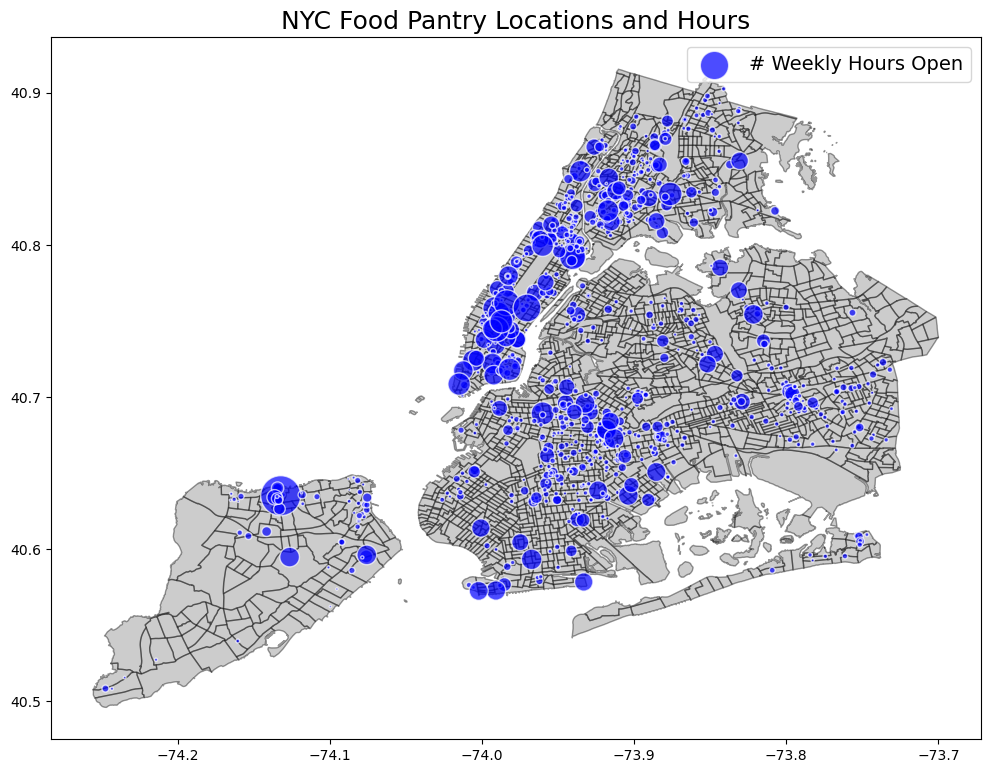

In [60]:
fig,(ax1)=plt.subplots(ncols=(1),nrows=(1),figsize=(12,12))
nyc_CT.plot(ax=ax1,alpha=0.4,color='grey',zorder=1,edgecolor='black');
gdf_final.plot(ax=ax1,color='blue',markersize = gdf_final['hours_open']*5,label='# Weekly Hours Open',edgecolor='white',alpha=0.7)
ax1.legend(fontsize=14)
ax1.set_title('NYC Food Pantry Locations and Hours',fontsize=18);
#plt.savefig('../figures/pantry_locations_and_hours.png');